In [4]:
import spotpy
import numpy as np
import pandas as pd
import subprocess
import shutil
import os
from pymail import alert

In [5]:
def parse_dates(df):
    return '%s-%s-%s'%(int(df.year),int(df.month),int(df.day))

In [6]:
obspath = '../../../greenness_timing/ameriflux/CA_p301/P301.pcl'
obs = pd.read_pickle(obspath)
obs = obs.resample('M').sum() # resample to monthly values
obs['ET'] = obs.tot_ET.copy()

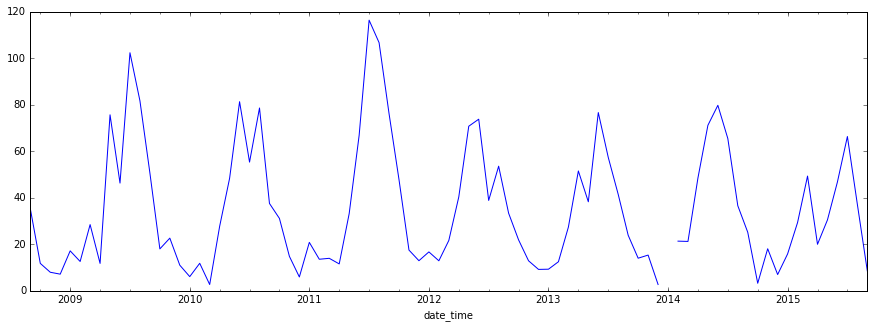

In [7]:
obs.ET.plot(figsize=(15,5))

In [8]:
forcingpath = '../providence/data/providence_upper_met_p.pcl'
force = pd.read_pickle(forcingpath)

In [9]:
force.columns

Index([u'Tave', u'Tmax', u'Tmin', u'datetime', u'precip', u'flag',
       u'rain_duration'],
      dtype='object')

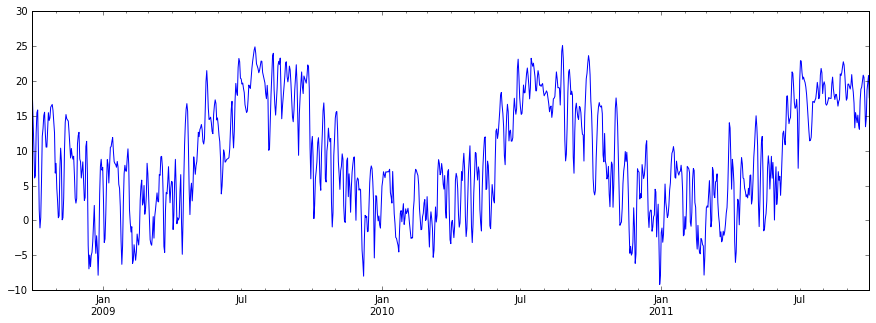

In [10]:
force.Tave.plot(figsize=(15,5))

In [11]:
print 'start day: %s'%np.max([force.index.min(),obs.index.min()])
print 'end day: %s'%np.min([force.index.max(),obs.index.max()])

start day: 2008-10-01 00:00:00
end day: 2011-09-30 00:00:00


In [12]:
class spotpy_setup():
    # the __init__ runs just once at the begining of the optimization
    def __init__(self):
    # define the run number
        # define the parameters for the model
        self.params = [spotpy.parameter.Uniform('gw1',0.0,0.4),
        spotpy.parameter.Uniform('gw2',0.0,1.0),
        spotpy.parameter.Uniform('m',0.01,20.),
        spotpy.parameter.Uniform('ksat',1.,600.),
        spotpy.parameter.Uniform('pa',0.8,1.2),
        spotpy.parameter.Uniform('po',0.00001,3.8),
        spotpy.parameter.Uniform('rd',0,5.0)]

        self.obspath = obspath
        self.outpath = '/RHESSys/providence/theo_p301_flux/out'
        
        self.start_date = pd.datetime(2008,10,1) # simulation spinup start (RHESSys format)
        self.end_date = pd.datetime(2011,9,30) # simulation end date (RHESSys format)
        self.a_start_date = '2008-10-1' # analysis start date, pandas format
        self.a_end_date = '2011-09-30' # analysis end date, pandas format
        
        # read in the observations
        obs = pd.read_pickle(self.obspath)[self.a_start_date:self.a_end_date]
        obs = obs.resample('M').sum()
        obs['ET'] = obs.tot_ET
        self.obs = obs.ET.as_matrix() # pull out the observations
        
        self.ct = 0 # counter
        
        self.evaldates = obs.index
        
    def parameters(self):
        # generate the parameters
        return spotpy.parameter.generate(self.params)


    def simulation(self,vector):
        
        gw1 = vector[0]
        gw2 = vector[1]
        m = vector[2]
        ksat = vector[3]
        pa = vector[4]
        po = vector[5]
        rootdepth = vector[6]
        soildepth = rootdepth + 4.
        
        strtyear = self.start_date.year
        strtmonth = self.start_date.month
        strtday = self.start_date.day
        endyear = self.end_date.year
        endmonth = self.end_date.month
        endday = self.end_date.day
        
        #create the output directory
        idx = self.ct
        
        # run the simulation using the rhessys script
        cmd = 'sh /RHESSys/providence/theo_p301_flux/scripts/rhessys_opt_ET.sh %s %s %s %s %s %s %s %s %s %s %s %s %s %s %s'%(gw1,
        gw2,m,ksat,pa,po,rootdepth,soildepth,strtyear,strtmonth,strtday,endyear,endmonth,endday,int(idx))
        
        #print cmd
        
        subprocess.call(cmd,shell=True)
        
        # load the output
        sim = pd.read_table('/RHESSys/providence/theo_p301_flux/out/opt/%s_basin.daily'%(idx),sep = ' ')
        sim['datetime'] = sim.apply(parse_dates,axis=1)
        sim.index = pd.DatetimeIndex(sim.datetime)
        sim = sim[self.a_start_date:self.a_end_date]
        sim['ET'] = sim['evap'] + sim['trans']
        sim = sim.resample('M').sum()
        
        # delete the output
        cmd = 'rm /RHESSys/providence/theo_p301_flux/out/opt/%s_*'%(idx)
        subprocess.call(cmd,shell=True)
        
        self.ct += 1 # increment counter
        return sim.ET.as_matrix()


    def evaluation(self,evaldates=False):
        # function to return the evaluation data
        if evaldates==True:
            return self.evaldates
        
        if evaldates==False:
            return self.obs


    def objectivefunction(self,simulation,evaluation):
        # compute the objective function
        objectivefunction = spotpy.objectivefunctions.nashsutcliff(evaluation,simulation) # we want to maximize this function
        return objectivefunction

## Notes:

In [13]:
spotpy_setup = spotpy_setup()

sampler = spotpy.algorithms.sceua(spotpy_setup,dbname='p301_ET1opt',dbformat='csv')

In [14]:
results = sampler.getdata()

In [15]:
tmp = pd.DataFrame(results)

In [16]:
tmp.sort_values(by='like1',ascending=False,inplace=True)

In [18]:
tmp.head().round(2)

,like1,pargw1,pargw2,parm,parksat,parpa,parpo,parrd,simulation1,simulation2,...,simulation28,simulation29,simulation30,simulation31,simulation32,simulation33,simulation34,simulation35,simulation36,chain
15047,-27.24,0.12,0.37,0.04,213.63,0.85,2.60,1.11,63.45,39.07,...,22.17,24.41,42.03,33.30,47.43,63.41,93.94,122.87,97.66,4.0
23275,-27.25,0.20,0.32,0.06,124.14,0.92,3.30,1.10,63.45,39.07,...,22.17,25.12,42.38,33.30,48.97,63.41,93.94,122.87,97.66,3.0
6226,-27.25,0.03,0.82,0.03,160.95,0.86,2.94,1.07,63.45,39.07,...,22.17,24.41,42.03,33.37,47.07,63.41,93.94,122.87,97.66,1.0
23791,-27.28,0.15,0.43,0.04,238.55,0.85,2.59,1.19,63.45,39.07,...,22.17,24.41,42.03,33.30,47.43,63.41,93.94,122.87,97.66,2.0
16615,-27.30,0.16,0.37,0.07,236.15,0.83,3.35,1.13,63.45,39.07,...,22.17,25.12,42.38,33.60,49.23,63.41,93.94,122.87,97.66,0.0


In [16]:
sim = tmp.iloc[0,8:-1].as_matrix()

In [17]:
df = pd.DataFrame()
df['Observations'] = spotpy_setup.obs
df['Simulation'] = sim
df.index = pd.DatetimeIndex(pd.date_range(start='2008-10-15',freq='M',periods=len(sim)))

In [19]:
df.to_pickle('./data/p301_ET_opt1_15047_NSE0_29.pcl')

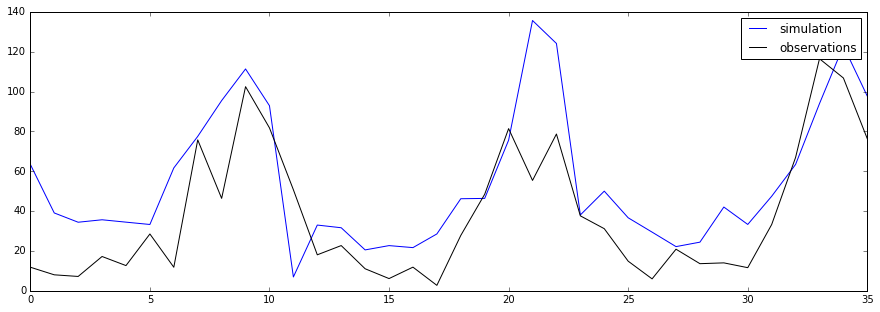

In [17]:
plt.figure(figsize=(15,5))
plt.plot(sim,'b',label='simulation')
#for i in xrange(len(sims)):
#    plt.plot(sims[i,:],'0.5',label='simulation')
#    
plt.plot(spotpy_setup.obs,'k',label='observations')
plt.legend()

In [18]:
from hydro import objective_fxns as obfx

In [19]:
obfx.nashsut(spotpy_setup.obs,sim)

0.28613305477321815

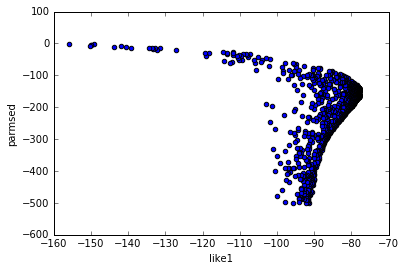

In [21]:
tmp.plot.scatter('like1','parmsed')

## Scratch

In [23]:
sampler.evaluation

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [26]:
sampler.objectivefunction(sampler.evaluation,sim)/100.

0.53044912445844605

In [20]:
 = pd.read_table('/RHESSys/Como/out/opt/0_basin.daily',sep=' ')
tmp['datetime'] = tmp.apply(parse_dates,axis=1)
tmp.index = pd.DatetimeIndex(tmp.datetime)
tmp = tmp[spotpy_setup.a_start_date:spotpy_setup.a_end_date]

In [21]:
tmp.shape

(7671, 74)

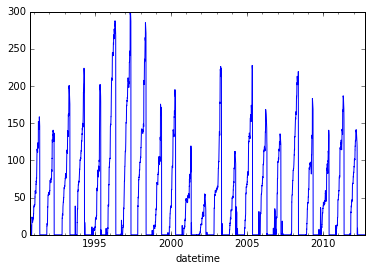

In [19]:
tmp.snowpack.plot()

In [57]:
spotpy_setup.a_start_date

'1991-10-1'